### Agenda
- Pré-processamento
- Visualização da série
- Estacionar a série
- Gráficos de correlação e autocorrelação (para saber os lags que usar)
- Implementação do modelo baseado nos dados
- Previsão

#### Literature:
    - https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
    - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    - https://www.youtube.com/watch?v=2XGSIlgUBDI
    - https://www.youtube.com/watch?v=gLY-DWUNOgE&t=151s
    - https://www.youtube.com/watch?v=3UmyHed0iYE&t=33s
    - https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
    - https://www.youtube.com/watch?v=v7rZpT8NCbk
    - https://medium.com/@ozdogar/time-series-forecasting-using-sarima-python-8db28f1d8cfc

#### Imports

In [1]:
%run UtilsNew.ipynb

In [2]:
from scipy import stats
import statsmodels.tsa.stattools as ts
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from time import time
from sklearn.metrics import mean_absolute_error

set_plot_size(15, 3)

#### Carregando os dados
Como exemplo, foram usados os dados de 2024 até agora, da estação A001 (Brasilia)

In [3]:
raw_anual_df = pd.read_csv("data/dados_anual.csv", sep=";")

In [4]:
anual_df = pre_processing(raw_anual_df)

#### Qual horário devemos considerar?
Vamos verificar quais horários são revelantes 
- **Verificar para outras estações e epocas**
- **Verificar que hora o sol nasce e se põe nos estados**

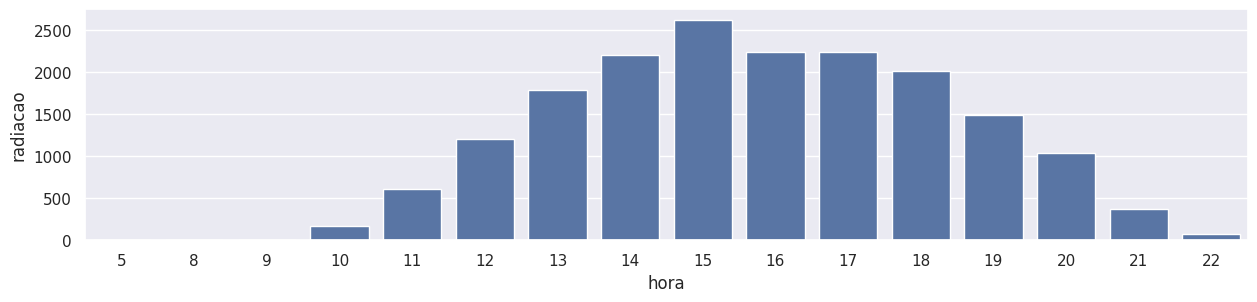

In [5]:
cut_anual_df = filter_between(anual_df, "data", "2024-01-01", "2024-02-01")
cut_anual_df = cut_anual_df[["data_hora", "radiacao", "temp_ins_c"]]

cut_anual_df["hora"] = cut_anual_df["data_hora"].dt.hour

cut_anual_df = cut_anual_df[["hora", "radiacao"]].groupby(['hora']).mean().reset_index()

plot = sns.barplot(cut_anual_df, x="hora", y="radiacao")

### Verificando outra estação
Para ter certeza, iremos verificar a estação de Mossoró (A318), no RN

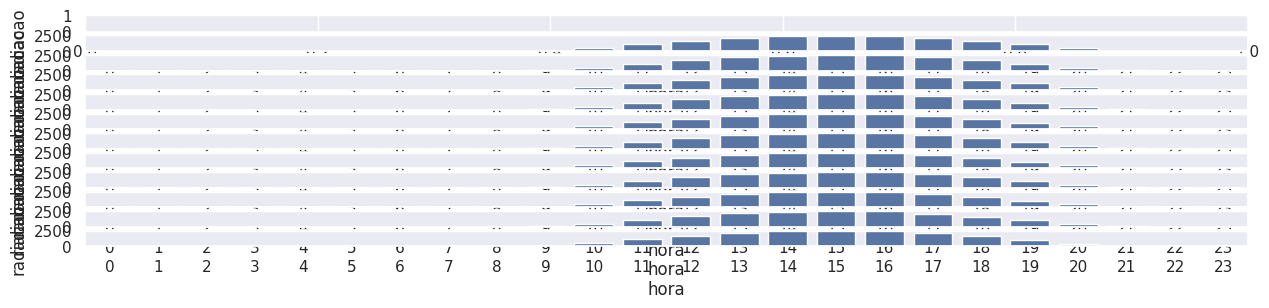

In [6]:
raw_anual_rn_df = pd.read_csv("data/dados_rn_anual.csv", sep=";")
anual_rn_df = pre_processing(raw_anual_rn_df)

fig, axs = plt.subplots(nrows=12)

for i in range(1, 12):
    cut_anual_df = filter_between(anual_df, "data", "2024-" + str(i + 1) + "-01", "2024-" + str(i + 1) + "-01")
    cut_anual_df = anual_rn_df[["data_hora", "radiacao", "temp_ins_c"]]
    
    cut_anual_df["hora"] = cut_anual_df["data_hora"].dt.hour
    
    cut_anual_df = cut_anual_df[["hora", "radiacao"]].groupby(['hora']).mean().reset_index()
    
    sns.barplot(cut_anual_df, x="hora", y="radiacao", ax=axs[i])

Vamos manter o intervalo, como visto na primeira estação, a partir da 11 e até as 21 que temos valores relevates e filtrar os dados dentro desse intervalo. Entrentanto, é necessaŕio adaptar o filtro de acordo com a estação.

In [7]:
anual_df["hora"] = anual_df["data_hora"].dt.hour
anual_df = filter_between(anual_df, "hora", 11, 21)

### A série é estacionária?

#### Análise visual
##### Toda a série
Aqui foi feito um resample para agrupar a série por dia, só para termos uma ideia do comportamento diário ao longo do ano. 

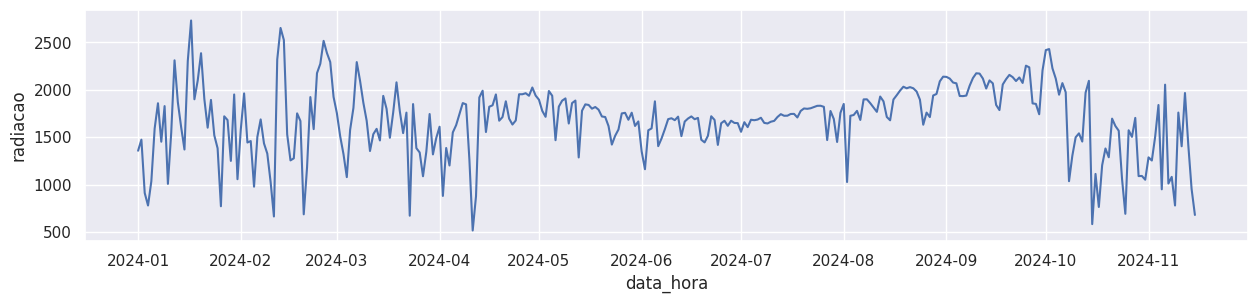

In [8]:
anual_df_resampled = anual_df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()
plot = sns.lineplot(data=anual_df_resampled, x="data_hora", y="radiacao")

Obtendo um recorte onde uma possivel tendência mais evidente.

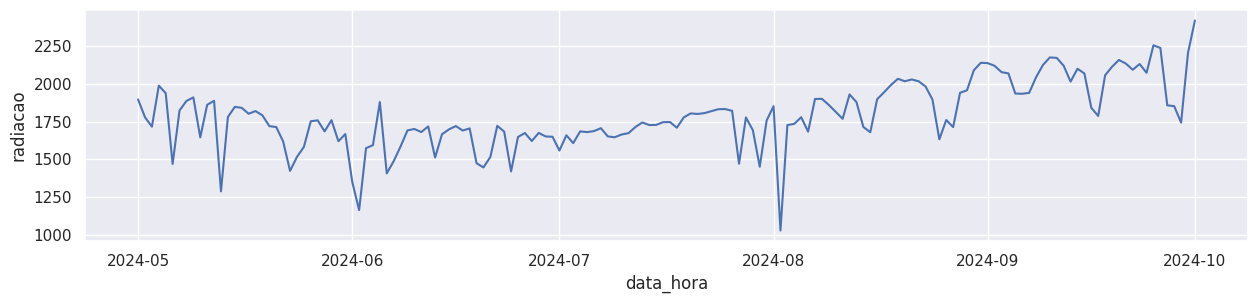

In [9]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")

cut_anual_df_resampled = cut_anual_df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()
plot = sns.lineplot(data=cut_anual_df_resampled, x="data_hora", y="radiacao")

Visualizando um recorte semanal para tentar identificar uma possivel sazonalidade

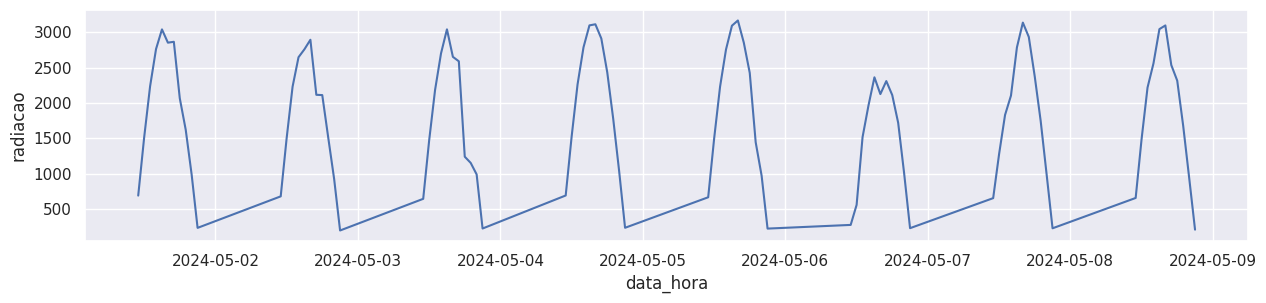

In [10]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-05-08")
plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="radiacao")

#### Teste de estacionariedade
##### AdFuler

In [11]:
def adfuller_test(df):
    result=ts.adfuller(df)
    labels = ['Teste estatístico ADF','p-valor','Num Lags','Numero de observações']
    for value, label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.")
    else:
        print("Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.")


##### Teste com o recorte visualmente com tendência, sem resample

Teste estatístico ADF : -3.4022381060482396
p-valor : 0.010882810937512104
Num Lags : 25
Numero de observações : 1663
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


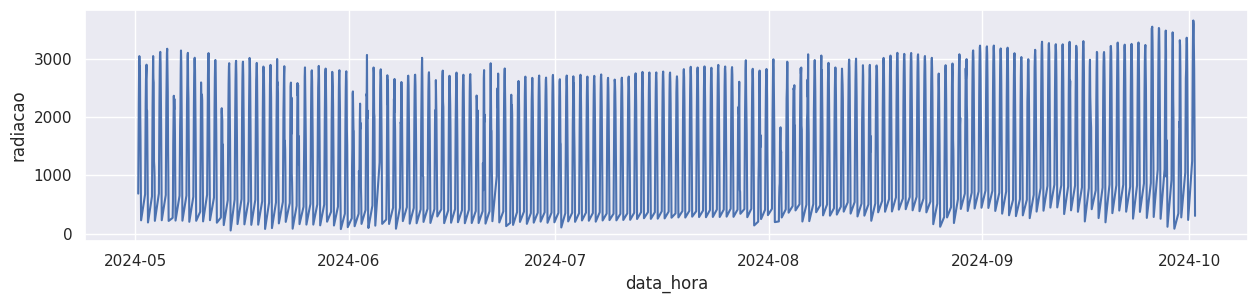

In [12]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["radiacao", "data_hora"]]

plot = sns.lineplot(data=cut_anual_df.set_index("data_hora"), x="data_hora", y="radiacao")
adfuller_test(cut_anual_df["radiacao"])

##### Teste com o recorte visualmente com tendência, com resample

Teste estatístico ADF : 0.08262236330769321
p-valor : 0.9648544181949681
Num Lags : 10
Numero de observações : 143
Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.


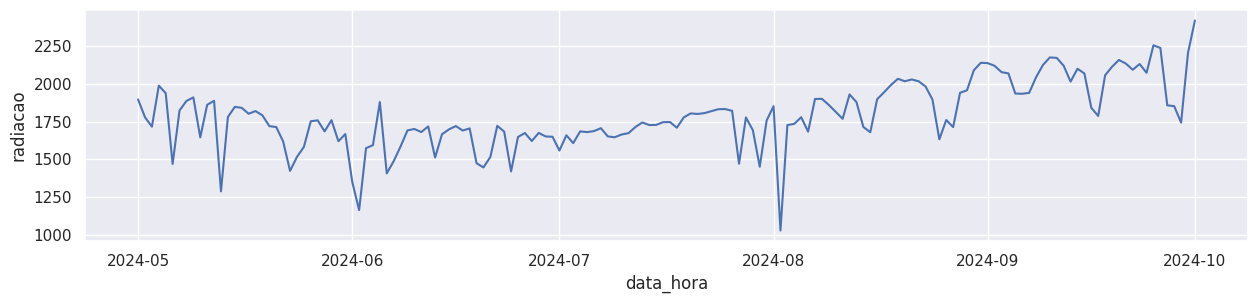

In [13]:
cut_anual_df_resampled = cut_anual_df.set_index("data_hora").resample("D").mean()

plot = sns.lineplot(data=cut_anual_df_resampled, x="data_hora", y="radiacao")
adfuller_test(cut_anual_df_resampled["radiacao"])

##### Teste com a serie toda, sem resample

Teste estatístico ADF : -7.135399067951095
p-valor : 3.431550615532008e-10
Num Lags : 30
Numero de observações : 3478
Fortes evidências contra a hipotese nula(Ho), ou seja, pode ser rejeitada. Os dados não possuem uma raíz unitária, portanto tem estacionáriedade.


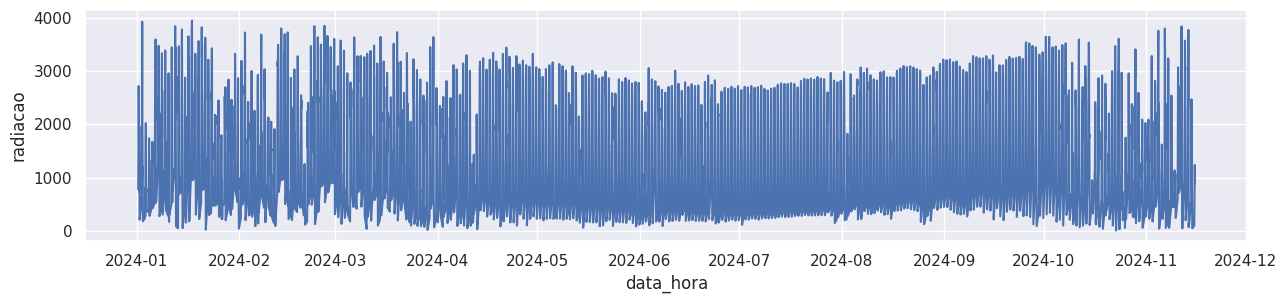

In [14]:
cut_anual_df = anual_df[["radiacao", "data_hora"]]

plot = sns.lineplot(data=cut_anual_df.set_index("data_hora"), x="data_hora", y="radiacao")
adfuller_test(cut_anual_df["radiacao"])

##### Teste com a serie toda, com resample

Teste estatístico ADF : -2.7332018884458265
p-valor : 0.06846699094152717
Num Lags : 9
Numero de observações : 310
Fracas evidências contra a hipotese nula(Ho), a série temporal possui uma raíz unitária, indicando que é não estacionária.


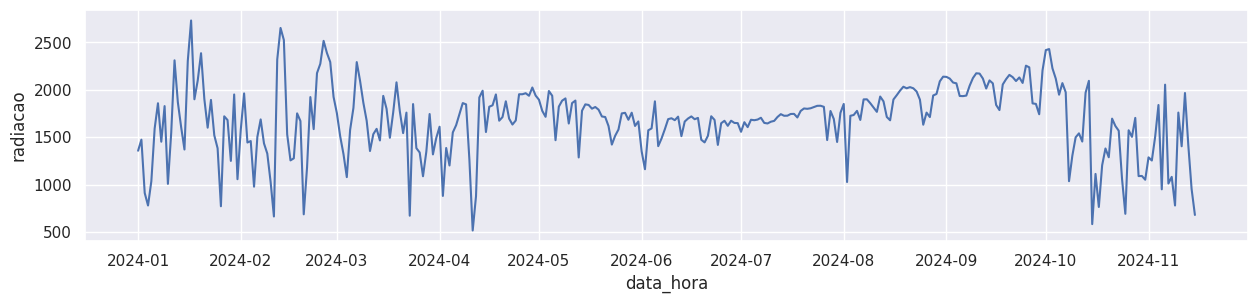

In [15]:
cut_anual_df = anual_df[["radiacao", "data_hora"]].set_index("data_hora").resample("D").mean()

plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="radiacao")
adfuller_test(cut_anual_df["radiacao"])

A série original (horária) não apresenta evidências suficientes para ser classificada como não estacionária. Por tanto, não haverá a etapa de diferenciação. **[MESMO ASSIM APLICAR]** para remover tendência (horaria) e sazonalidade (14?)

### Diferenciação

In [16]:
def diferenciacao_aditivo(df_temp, col, periods=1):
    df_temp["shift"] = df_temp[col].shift(periods=periods, fill_value=0)
    df_temp["diff"] = df_temp[col] - df_temp["shift"]

    return df_temp

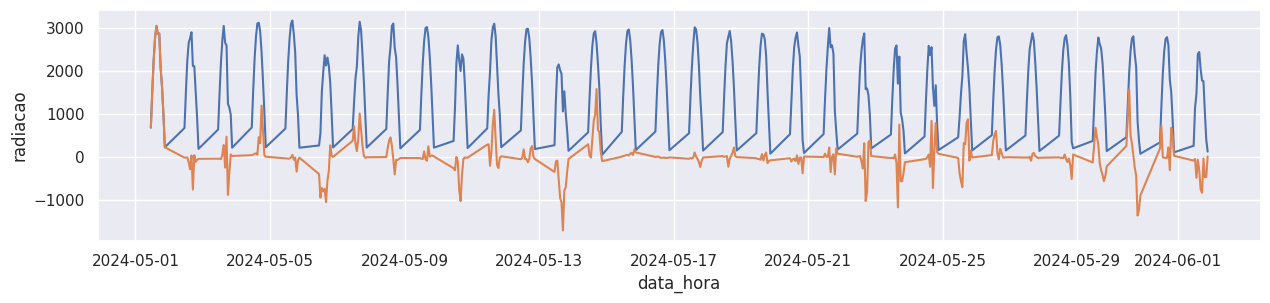

In [17]:
cut_anual_df = filter_between(anual_df, "data", "2024-05-01", "2024-06-01")[["data_hora", "radiacao"]]
# cut_anual_df = anual_df[["data_hora", "radiacao"]]
cut_anual_df["shift"] = cut_anual_df["radiacao"].shift(periods=11, fill_value=0)
cut_anual_df["diff"] = cut_anual_df["radiacao"] - cut_anual_df["shift"]


# cut_anual_df.head(50)
plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="radiacao")
plot = sns.lineplot(data=cut_anual_df, x="data_hora", y="diff")

### ACF e PACF
**ACF:** Calcula a correlação dado um lag, levando em consideração os intervalos;</br>
**PACF:** Calcula a correlação enter dois pontos, descosiderando os intervalos.

Configurando os parametros sazonais e não sazonais (p, d, q, P, D, Q, m):

Parametros não sazonais (p, d, q):

    p: Verifique o gráfico PACF para identificar o número de defasagens de autorregressão. Picos significativos em defasagens específicas sugerem valores apropriados para pp.
    d: Aplique diferenciação (tipicamente d=1d=1 para não estacionariedade) se a série mostrar uma tendência.
    q: Observe o gráfico ACF para determinar o componente da média móvel. Picos significativos em defasagens específicas sugerem valores apropriados para qq.

Parametros sazonais (P, D, Q, m):

    P: Verifique o PACF em múltiplos de 24 (para sazonalidade diária). Um pico no lag 24 sugere um componente autorregressivo.
    D: Use diferenciação sazonal (tipicamente D=1D=1) para remover padrões sazonais.
    Q: Verifique o ACF em múltiplos de 24 (ou outros períodos sazonais, se aplicável). Picos significativos em lags sazonais sugerem valores apropriados para QQ.
    Por exemplo, se houver padrões semanais, você também pode verificar o ACF e o PACF em múltiplos de 168 (ou seja, 7 dias × 24 horas).

**p:** AR model lags. Quantos lags eu quero usar no modelo</br> 
**d:** Differencing (quantas diferenciações eu apliquei)</br> 
**q:** MA lags. Aqui eu escolherei com base no ACF, em quantos picos com significancia surgirem (no grafico acima, dentro 40 surgiram 3)

Porém, se o ACF tem somente um pico, e não é exponencial, MA = 1. Mas, se o ACF é exponencial, tem varios picos, e o PACF tem somente um pico, dai o AR = 1

AFC = MA </br>
PAFC = AR 

#### Definindo
- AR ou p: responda a pergunta; o gafico PACF tem um decrescimento exponencial ou abrupto? Se é o primeiro, é 1. Se é o segundo, é 0 (?).

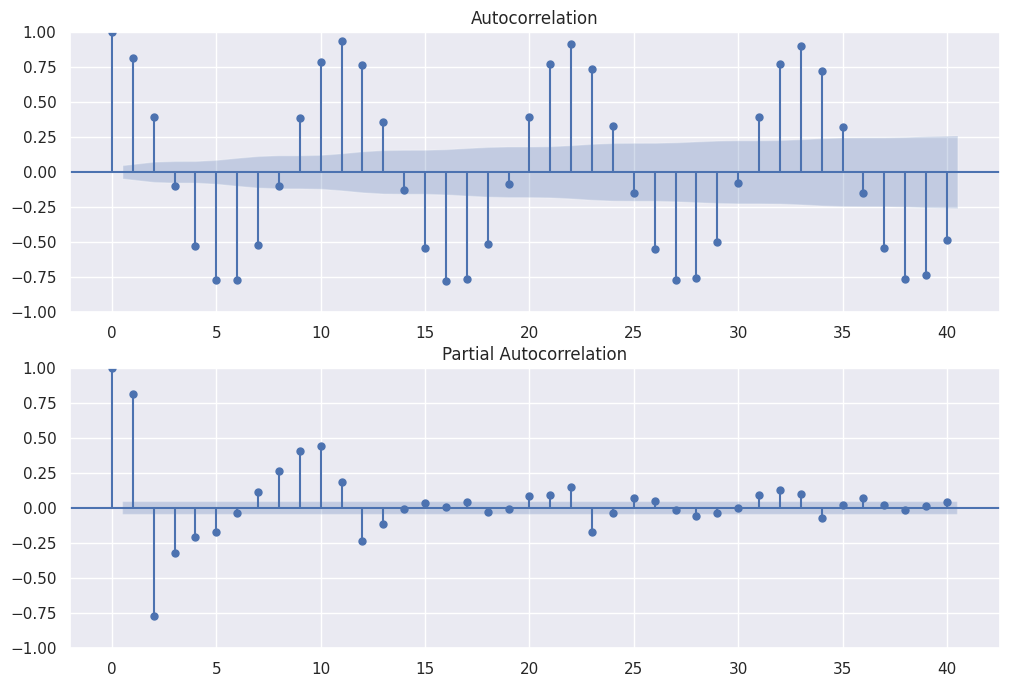

In [19]:
df_to_model = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_to_model,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_to_model,lags=40,ax=ax2)

## Aplicando o modelo

In [53]:
def apply_sarima(df, order, seasonal_order):
    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)

    model_fit = model.fit(trend="nc") #Vericiar o que é o nc

    print(model_fit.summary())

    return model_fit

def predict(model_fit, df_to_model, col, start, end):
    df_to_model['forecast'] = model_fit.predict(start=start,end=end,dynamic=True)
    df_to_model[[col,'forecast']].iloc[start-10:end].plot(figsize=(12,8))

def get_residual(df_to_model):
    df_residuos = df_to_model.iloc[1588:]
    df_residuos["diff"] = df_residuos["radiacao"] - df_residuos["forecast"]
    df_residuos["diff"].plot(figsize=(12,8))

    mae = mean_absolute_error(df_residuos["radiacao"], df_residuos["forecast"])
    print("Mean Absolut Error: ", mae)

def grid_search(df):
    p, d, q = 0, 0, 0
    _p, _d, _q, m = 1, 0, 3, 11
    
    my_order = (p, d, q)
    my_seasonal_order = (_p, _d, _q, m)

### Usando 1a config

In [57]:
p, d, q = 0, 0, 0
_p, _d, _q, m = 1, 0, 1, 11

df_to_model = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")

order = (p, d, q)
seasonal_order = (_p, _d, _q, m)

In [58]:
model_fit = apply_sarima(df_to_model, order, seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07080D+00    |proj g|=  7.65584D-03


 This problem is unconstrained.



At iterate    5    f=  7.07059D+00    |proj g|=  8.19069D-03

At iterate   10    f=  7.06902D+00    |proj g|=  1.87180D-04

At iterate   15    f=  7.06879D+00    |proj g|=  5.79995D-03

At iterate   20    f=  7.06826D+00    |proj g|=  3.11354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   5.792D-07   7.068D+00
  F =   7.0682540070433335     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                 SARIMAX Results                                  
Dep. Variable:                   radiacao   No. Observations:                 1689
Model:   

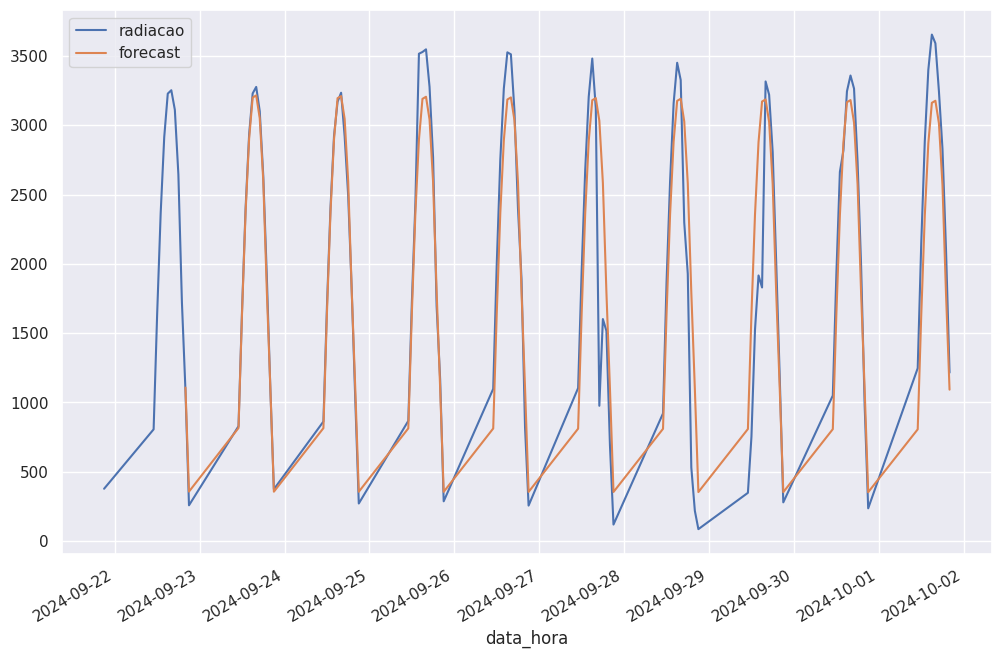

In [60]:
predict(model_fit, df_to_model, "radiacao", start=1588,end=1688)

Mean Absolut Error:  276.8913981063876


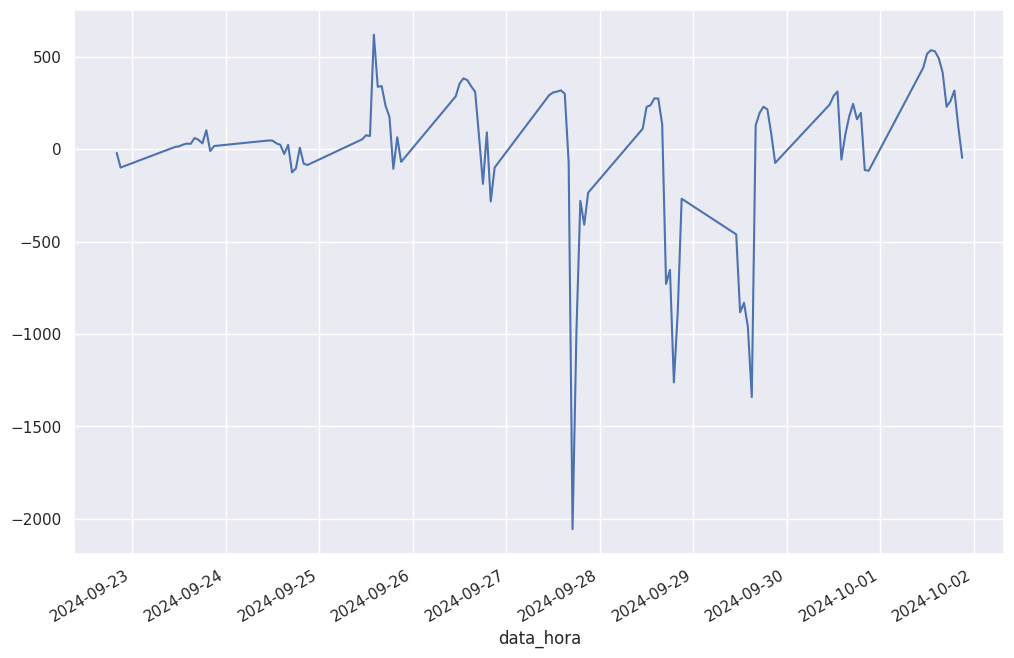

In [61]:
get_residual(df_to_model)

### Usando 2a config

In [30]:
p, d, q = 1, 0, 1
_p, _d, _q, m = 1, 0, 0, 11

order = (p, d, q)
seasonal_order = (_p, _d, _q, m)

df_to_model_2 = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")

In [31]:
model_fit = apply_sarima(df_to_model_2, order, seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73425D+00    |proj g|=  8.69159D-01


 This problem is unconstrained.



At iterate    5    f=  7.23599D+00    |proj g|=  7.94795D-03

At iterate   10    f=  7.22288D+00    |proj g|=  2.68995D-03

At iterate   15    f=  7.22012D+00    |proj g|=  1.62183D-02

At iterate   20    f=  7.20908D+00    |proj g|=  2.29925D-03

At iterate   25    f=  7.15676D+00    |proj g|=  3.85194D-02

At iterate   30    f=  7.04255D+00    |proj g|=  5.05476D-03
  ys=-1.567E-02  -gs= 9.258E-03 BFGS update SKIPPED

At iterate   35    f=  6.98782D+00    |proj g|=  3.37991D-02

At iterate   40    f=  6.98611D+00    |proj g|=  1.35166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     70      1     1

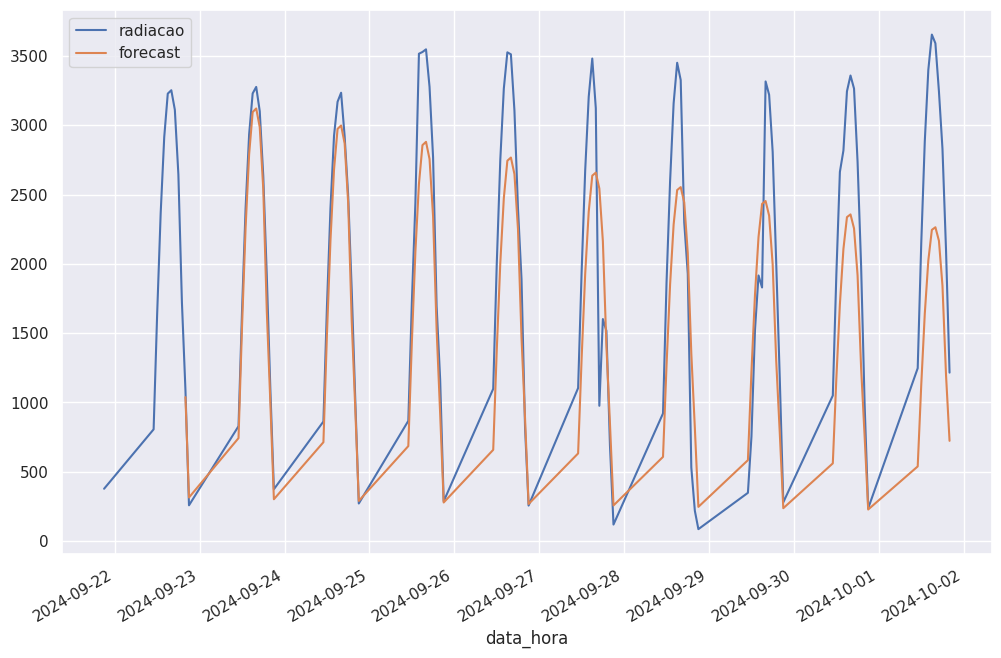

In [32]:
predict(model_fit, df_to_model_2, "radiacao", start=1588,end=1688)

Mean Absolut Error:  487.83018906087653


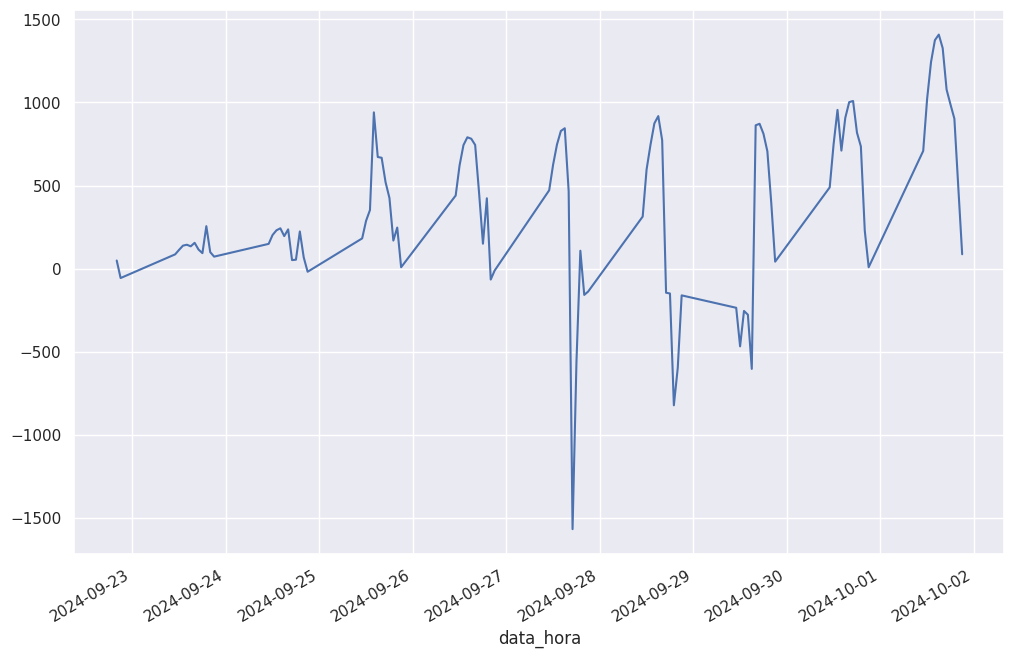

In [33]:
get_residual(df_to_model_2)

### Usando 3a config e aplicando diferenciação

In [45]:
p, d, q = 1, 1, 1
_p, _d, _q, m = 1, 1, 1, 11

order = (p, d, q)
seasonal_order = (_p, _d, _q, m)

df_to_model_3 = filter_between(anual_df, "data", "2024-05-01", "2024-10-01")[["data_hora", "radiacao"]].set_index("data_hora")

cut_anual_df = df_to_model_3
cut_anual_df["shift"] = df_to_model_3["radiacao"].shift(periods=11, fill_value=0)
cut_anual_df["diff"] = cut_anual_df["radiacao"] - cut_anual_df["shift"]

In [43]:
model_fit = apply_sarima(cut_anual_df["diff"], order, seasonal_order)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20850D+00    |proj g|=  2.93232D-02

At iterate    5    f=  7.18632D+00    |proj g|=  2.83764D-03

At iterate   10    f=  6.94963D+00    |proj g|=  1.77797D-01

At iterate   15    f=  6.88059D+00    |proj g|=  4.22963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   4.840D-06   6.881D+00
  F =   6.8805684234760029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

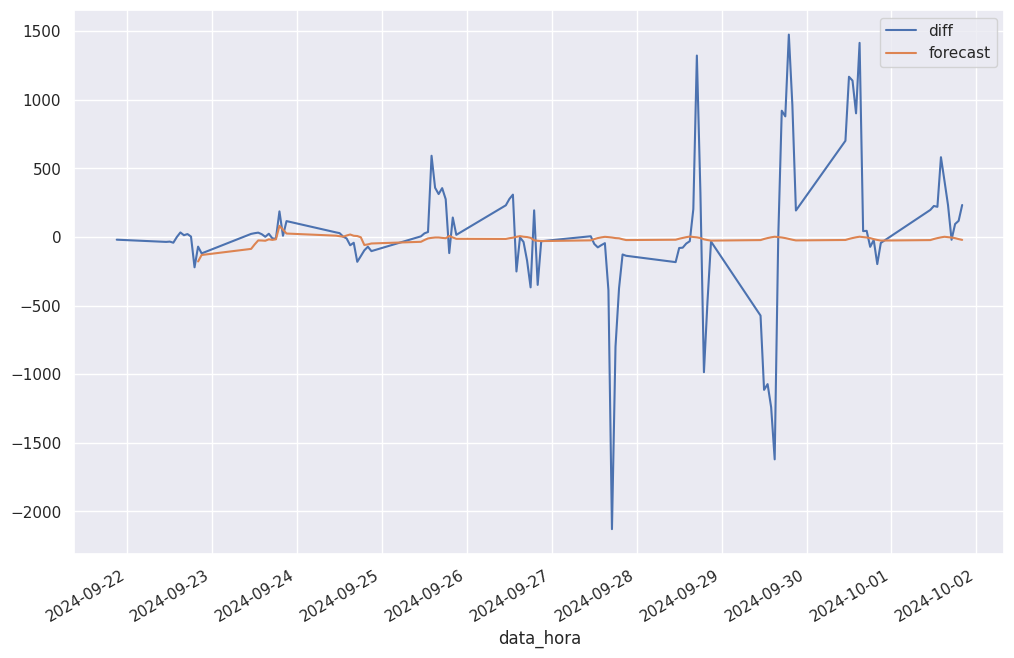

In [48]:
predict(model_fit, cut_anual_df, "diff", start=1588,end=1688)

Mean Absolut Error:  2071.4222886554885


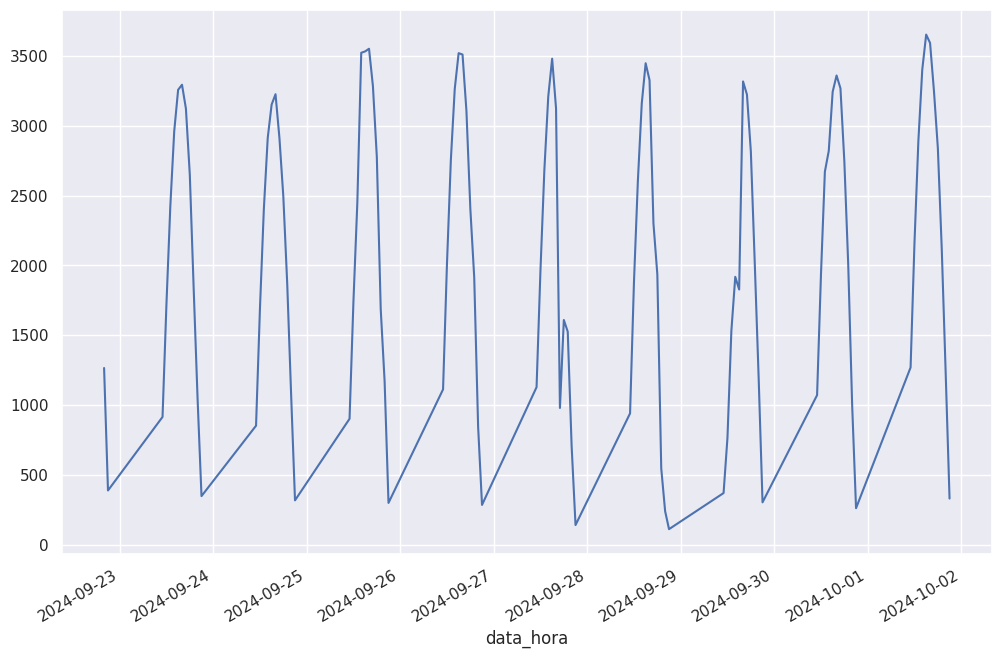

In [50]:
get_residual(cut_anual_df)